In [ ]:
import numpy as np
import ebsd_pattern as ep
import matplotlib.pyplot as plt
from scipy import interpolate, signal, ndimage, linalg
from skimage import transform as tf
from tqdm.auto import tqdm
from skimage import restoration, exposure

import GCC_Preprocess as gpp

%matplotlib widget


def get_patterns(up2, ang):
    # Get patterns
    obj = ep.get_pattern_file_obj(up2)
    obj.read_header()
    pats = obj.read_data(returnArrayOnly=True)
    # Get shape from ang
    with open(ang, 'r') as f:
        for line in f:
            if line.startswith('# NROWS:'):
                rows = int(line.replace('# NROWS:','').replace('\n','').strip())
            if line.startswith('# NCOLS_ODD:'):
                cols = int(line.replace('# NCOLS_ODD:','').replace('\n','').strip())
    # Reshape patterns
    pats = pats.reshape((rows, cols, pats.shape[1], pats.shape[2])).astype(np.float32)
    pats = (pats - pats.min(axis=(2,3))[:,:,None,None]) / (pats.max(axis=(2,3)) - pats.min(axis=(2,3)))[:,:,None,None]
    return pats


def clean_patterns(pats, background=True, equalize=True, gauss_sigma=1):
    background = ndimage.gaussian_filter(pats.mean(axis=(0,1)), 5)
    pats = pats - background[None,None]
    pats = (pats - pats.min(axis=(2,3))[:,:,None,None]) / (pats.max(axis=(2,3)) - pats.min(axis=(2,3)))[:,:,None,None]
    if gauss_sigma > 0:
        func_temp = lambda x: ndimage.gaussian_filter(x, gauss_sigma)
    else:
        func_temp = lambda x: x
    if equalize:
        func = lambda x: exposure.equalize_adapthist(func_temp(x), clip_limit=0.03)
    else:
        func = func_temp
    for i in tqdm(range(pats.shape[0])):
        for j in range(pats.shape[1]):
            pats[i, j] = func(pats[i, j])
    return pats


def view(*imgs, cmap='gray', titles=None):
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 4))
    if n == 1:
        axes = [axes]
    for i, img in enumerate(imgs):
        ax = axes[i]
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
    plt.show()

In [ ]:
up2 = "E:/cells/CoNi90-OrthoCells.up2"
ang = "E:/cells/CoNi90-OrthoCells.ang"
pats = get_patterns(up2, ang)
pats = clean_patterns(pats, equalize=False)

In [ ]:
def homography_to_elastic_deformation(H, PC):
    """Calculate the deviatoric deformation gradient from a homography using the projection geometry (pattern center).
    Note that the deformation gradient is insensitive to hydrostatic dilation.
    Args:
        H (np.ndarray): The homography matrix.
        PC (np.ndarray): The pattern center.
    Returns:
        np.ndarray: The deviatoric deformation gradient."""
    x01, x02, DD = PC
    h11, h12, h13, h21, h22, h23, h31, h32 = H
    beta0 = 1 - h31 * x01 - h32 * x02
    Fe11 = 1 + h11 + h31 * x01
    Fe12 = h12 + h32 * x01
    Fe13 = (h13 - h11*x01 - h12*x02 + x01*(beta0 - 1))/DD
    Fe21 = h21 + h31 * x02
    Fe22 = 1 + h22 + h32 * x02
    Fe23 = (h23 - h21*x01 - h22*x02 + x02*(beta0 - 1))/DD
    Fe31 = DD * h31
    Fe32 = DD * h32
    Fe33 = beta0
    return np.array([[Fe11, Fe12, Fe13], [Fe21, Fe22, Fe23], [Fe31, Fe32, Fe33]]) / beta0


def correct_geometry(H, PC, delPC):
    x01, x02, DD = PC
    d1, d2, dDD = delPC
    alpha = (DD - dDD) / DD
    TS_inv = np.array([[1/alpha,       0, -(d1 + x01 * (alpha - 1)) / alpha],
                       [      0, 1/alpha, -(d2 + x02 * (alpha - 1)) / alpha],
                       [      0,       0,                                 1]])
    Wp = W(H)
    Wp_hat = TS_inv.dot(Wp)
    Wp_hat = Wp_hat / Wp_hat[2, 2]
    p = np.array([Wp_hat[0, 0] - 1, Wp_hat[0, 1],     Wp_hat[0, 2],
                  Wp_hat[1, 0],     Wp_hat[1, 1] - 1, Wp_hat[1, 2],
                  Wp_hat[2, 0],     Wp_hat[2, 1]])
    return p


def normalize(img):
    """Zero-mean normalize an image with unit standard deviation.
    Note that the standard deviation is multiplied by the number of pixels minus one.
    Args:
        img (np.ndarray): The image to normalize.
    Returns:
        np.ndarray: The normalized image."""
    # img = (img - img.min()) / (img.max() - img.min())
    img_bar = img.mean()
    dimg_tilde = np.sqrt(((img - img_bar)**2).sum())
    return (img - img_bar) / dimg_tilde


def jacobian(xi):
    _1 = np.ones(xi.shape[1])
    _0 = np.zeros(xi.shape[1])
    out0 = np.array([[xi[0], xi[1],   _1,    _0,    _0,   _0,    -xi[0]**2, -xi[1]*xi[0]]])
    out1 = np.array([[   _0,    _0,   _0, xi[0], xi[1],   _1, -xi[0]*xi[1],    -xi[1]**2]])
    return np.vstack((out0, out1))


def W(p):
    """Return the shape function matrix for the given homography parameters.
    Args:
        p (np.ndarray): The homography parameters.
    Returns:
        np.ndarray: The shape function matrix."""
    return np.array([[1 + p[0],     p[1], p[2]],
                     [    p[3], 1 + p[4], p[5]],
                     [    p[6],     p[7],    1]])


def warp_and_subset(img, p, subset_slice):
    # Normalize the image
    img = normalize(img)

    # Get coordinates
    x = np.arange(img.shape[1]) - img.shape[1] / 2
    y = np.arange(img.shape[0]) - img.shape[0] / 2
    X, Y = np.meshgrid(x, y)
    xi = np.array([Y[subset_slice].flatten(), X[subset_slice].flatten()])

    # Compute the intensity gradients of the subset
    spline = interpolate.RectBivariateSpline(x.flatten(), y.flatten(), img, kx=5, ky=5)

    # Deform the image
    xi_prime = get_xi_prime(xi, p)
    img_deformed = spline(xi_prime[0], xi_prime[1], grid=False).reshape(img[subset_slice].shape)
    return img_deformed


def deform(xi, spline, p):
    xi_prime = get_xi_prime(xi, p)
    return spline(xi_prime[0], xi_prime[1], grid=False)


def reference_precompute(R, subset_slice):
    # Compute the subset's intensities. They are zero mean normalized.
    r = normalize(R)[subset_slice].flatten()

    # Get coordinates
    x = np.arange(R.shape[1]) - R.shape[1] / 2
    y = np.arange(R.shape[0]) - R.shape[0] / 2
    X, Y = np.meshgrid(x, y)
    xi = np.array([Y[subset_slice].flatten(), X[subset_slice].flatten()])

    # Compute the intensity gradients of the subset
    spline = interpolate.RectBivariateSpline(x, y, R, kx=5, ky=5)
    GRx = spline(xi[0], xi[1], dx=1, dy=0, grid=False)
    GRy = spline(xi[0], xi[1], dx=0, dy=1, grid=False)
    GR = np.vstack((GRx, GRy)).reshape(2, 1, -1).transpose(1, 0, 2)  # 2x1xN
    r = spline(xi[0], xi[1], grid=False).flatten()
    r_zmsv = np.sqrt(((r - r.mean())**2).sum())
    r = (r - r.mean()) / r_zmsv

    # Get the reference intensities
    # r = spline(xi[0], xi[1], grid=False)
    # r = normalize(r)

    # Compute the jacobian of the shape function
    Jac = jacobian(xi)  # 2x8xN

    # Multiply the gradients by the jacobian
    NablaR_dot_Jac = np.einsum('ilk,ljk->ijk', GR, Jac)[0]  #1x8xN

    # Compute the Hessian
    H = 2 / r_zmsv**2 * NablaR_dot_Jac.dot(NablaR_dot_Jac.T)
    
    return r, r_zmsv, NablaR_dot_Jac, H, xi


def target_precompute(T):
    # Get coordinates
    x = np.arange(T.shape[1]) - T.shape[1] / 2
    y = np.arange(T.shape[0]) - T.shape[0] / 2

    # Compute the intensity gradients of the subset
    T_spline = interpolate.RectBivariateSpline(x.flatten(), y.flatten(), normalize(T), kx=5, ky=5)
    
    return T_spline


def dp_norm(dp, xi):
    xi1max = xi[0].max()
    xi2max = xi[1].max()
    ximax = np.array([xi1max, xi2max])
    dp_i0 = np.array([dp[0], dp[1]]) * ximax
    dp_i1 = np.array([dp[3], dp[4]]) * ximax
    dp_i2 = np.array([dp[6], dp[7]]) * ximax
    out = np.sqrt((dp_i0**2).sum() + (dp_i1**2).sum() + (dp_i2**2).sum() + (dp[2]**2 + dp[5]**2))
    return out


def get_xi_prime(xi, p):
    Wp = W(p)
    xi_3d = np.vstack((xi, np.ones(xi.shape[1])))
    xi_prime = Wp.dot(xi_3d)
    return xi_prime[:2] / xi_prime[2]


def IC_GN(R, T, subset_slice=None, conv_tol=1e-5, max_iter=10000, p0=None, verbose=False):
    ### Handle inputs
    # Set up the subset slice
    if subset_slice is None:
        subset_slice = (slice(None), slice(None))
    # Set up the initial guess
    if p0 is None:
        p0 = np.zeros(8, dtype=np.float32)
    # Setup the target patterns
    if T.ndim == 2:
        T = T[None]  # (1, H, W)
    
    p = p0.copy()

    # Precompute values for the reference subset
    r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(R, subset_slice)
    
    # Start loop over targets
    for i in range(T.shape[0]):
        
        # Precompute the target subset
        T_spline = target_precompute(T)

        # Run the iterations
        if verbose:
            print("Running iterations...")
        num_iter = 0
        updates = []
        vrange = None
        while num_iter < max_iter:
            # Warp the target subset
            num_iter += 1
            t_deformed = deform(xi, T_spline, p)
            t_deformed = normalize(t_deformed)

            # Compute the residuals
            e = r - t_deformed

            # Copmute the gradient of the correlation criterion
            dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1
        
            # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
            c, lower = linalg.cho_factor(H)
            dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]

            # Update the parameters
            norm = dp_norm(dp, xi)
            Wp = W(p)
            Wp = Wp.dot(np.linalg.inv(W(dp)))

            Wp = Wp / Wp[2, 2]
            p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                        Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                        Wp[2, 0], Wp[2, 1]])

            # Store the update
            updates.append(norm)

            # Check for convergence
            if norm < conv_tol:
                break
    return p


In [ ]:
T = pats[0, -1]
R = pats[0, 0]
subset_slice = (slice(R.shape[0] // 2 - 64, R.shape[0] // 2 + 64),
                slice(R.shape[1] // 2 - 64, R.shape[1] // 2 + 64))
p0 = gpp.GCC_Initial_Guess(R, T)
p, num_iter, norms = IC_GN(R, T, subset_slice=subset_slice, p0=p0, verbose=True, max_iter=50, conv_tol=1e-7)
print("{:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(*p0))
print("{:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(*p))

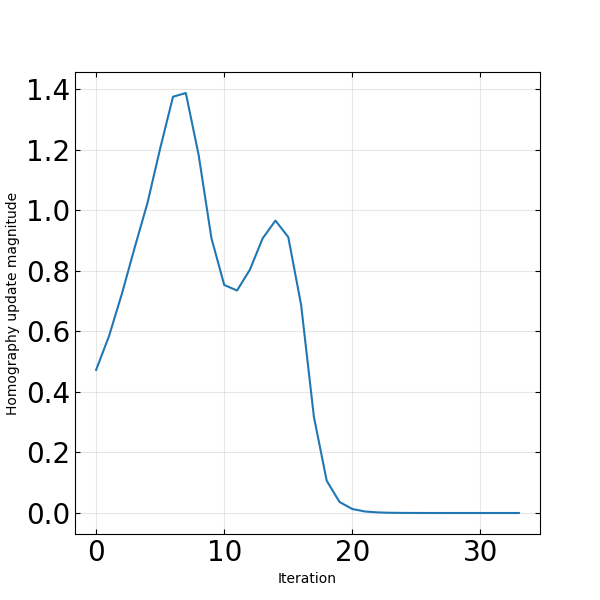

In [182]:
def standardize_axis(ax, **kwargs):
    new_params = {
        "figure.facecolor": "w",
        "figure.figsize": (12, 4),
        "lines.markersize": 10,
        "font.size": 22,
        "axes.grid": False,
    }
    plt.rcParams.update(new_params)
    plt.rcParams["font.family"] = "Arial"
    kwargs["labelsize"] = kwargs.get("labelsize", 20)
    kwargs["labelcolor"] = kwargs.get("labelcolor", "k")
    kwargs["direction"] = kwargs.get("direction", "in")
    kwargs["top"] = kwargs.get("top", True)
    kwargs["right"] = kwargs.get("right", True)
    ax.tick_params(axis="both", which="both", **kwargs)
    ax.grid(alpha=0.3, which="major")
    ax.grid(alpha=0.1, which="minor")

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(norms)
ax.set_xlabel('Iteration')
ax.set_ylabel('Homography update magnitude')
standardize_axis(ax)
plt.show()


In [ ]:
print(homography, p, num_iter)
R_0 = warp_and_subset(R, np.zeros(8), subset_slice)
T_0 = warp_and_subset(T, np.zeros(8), subset_slice)
print(R_0.min(), R_0.max(), R_0.mean(), R.min(), R.max(), R.mean())
T_1 = warp_and_subset(T, homography, subset_slice)
T_2 = warp_and_subset(T, p, subset_slice)
e = R_0 - T_0
e_1 = R_0 - T_1
e_2 = R_0 - T_2
plt.close("all")
view(R_0, T[subset_slice], e, titles=["R", "T", "e"])
view(R_0, T_1, e_1, titles=["R_1", "T_1", "e_1"])
view(R_0, T_2, e_2, titles=["R_2", "T_2", "e_2"])

In [ ]:
def get_xi_prime(xi, p):
    Wp = W(p)
    xi_3d = np.vstack((xi, np.ones(xi.shape[1])))
    xi_prime = Wp.dot(xi_3d)[:2]
    return xi_prime

img = pats[1, 1]
p = homography
subset_slice = (slice(img.shape[0] // 2 - 50, img.shape[0] // 2 + 50),
                slice(img.shape[1] // 2 - 50, img.shape[1] // 2 + 50))

# Compute the homography
img = normalize(img)

# Get coordinates
x = np.arange(img.shape[1]) - img.shape[1] / 2
y = np.arange(img.shape[0]) - img.shape[0] / 2
X, Y = np.meshgrid(x, y)
xi = np.array([Y[subset_slice].flatten(), X[subset_slice].flatten()])
# xi = np.array([Y.flatten(), X.flatten()])

# Compute the intensity gradients of the subset
spline = interpolate.RectBivariateSpline(x.flatten(), y.flatten(), img, kx=5, ky=5)

# Deform the image
xi_prime = get_xi_prime(xi, p)
img_deformed = spline(xi_prime[0], xi_prime[1], grid=False).reshape(img[subset_slice].shape)
# img_deformed = spline(xi[0], xi[1], grid=False).reshape(img[subset_slice].shape)

plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(6, 3))
ax[0].imshow(img[subset_slice], cmap='gray')
ax[1].imshow(img_deformed, cmap='gray')
ax[2].imshow(img[subset_slice] - img_deformed, cmap='gray')
plt.tight_layout()
plt.show()
